In [10]:
%pip install mplsoccer numpy pandas matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mplsoccer import Pitch, VerticalPitch, Sbopen

In [23]:
parser = Sbopen()
df_events,related,freeze,tactics = parser.event(69301)
team1,team2=df_events.team_name.unique()
shots = df_events.loc[df_events['type_name']=='Shot'].set_index('id')   

In [10]:
competitions = Sbopen("competitions")

competitions

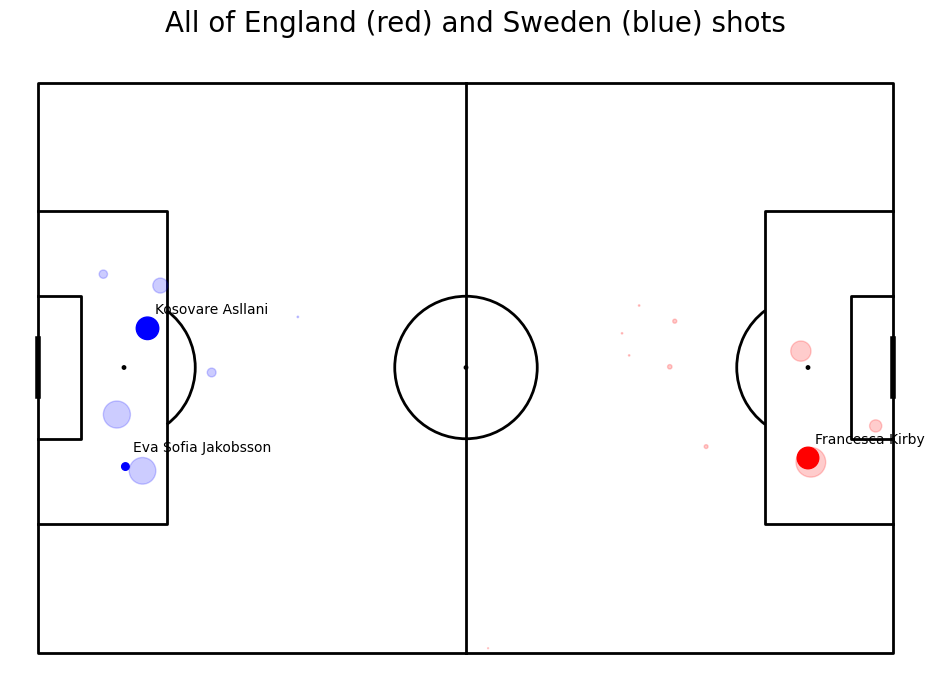

In [11]:
pitch=Pitch(line_color='black')
fig,ax=pitch.draw(figsize=(10,7))
pitchLengthX=120
pitchWidthY=80
for i,shot in shots.iterrows():
    x=shot['x']
    y=shot['y']
    goal=shot['outcome_name']=='Goal'
    team_name=shot['team_name']
    circleSize=shot["shot_statsbomb_xg"]*15

    if (team_name==team1):
        if goal:
            shotCircle=plt.Circle((x,y),circleSize,color="red")
            plt.text(x+1,y-2,shot['player_name'])
        else:
           shotCircle=plt.Circle((x,y),circleSize,color="red")
           shotCircle.set_alpha(0.2)

    else:
        if goal:
            shotCircle=plt.Circle((pitchLengthX-x,pitchWidthY-y),circleSize,color="blue")
            plt.text(pitchLengthX-x+1,pitchWidthY-y-2,shot['player_name'])
        else:
           shotCircle=plt.Circle((pitchLengthX-x,pitchWidthY-y),circleSize,color="blue")
           shotCircle.set_alpha(0.2)
    ax.add_patch(shotCircle)
fig.suptitle("All of England (red) and Sweden (blue) shots",fontsize=20)
fig.set_size_inches(10,7)
plt.show()


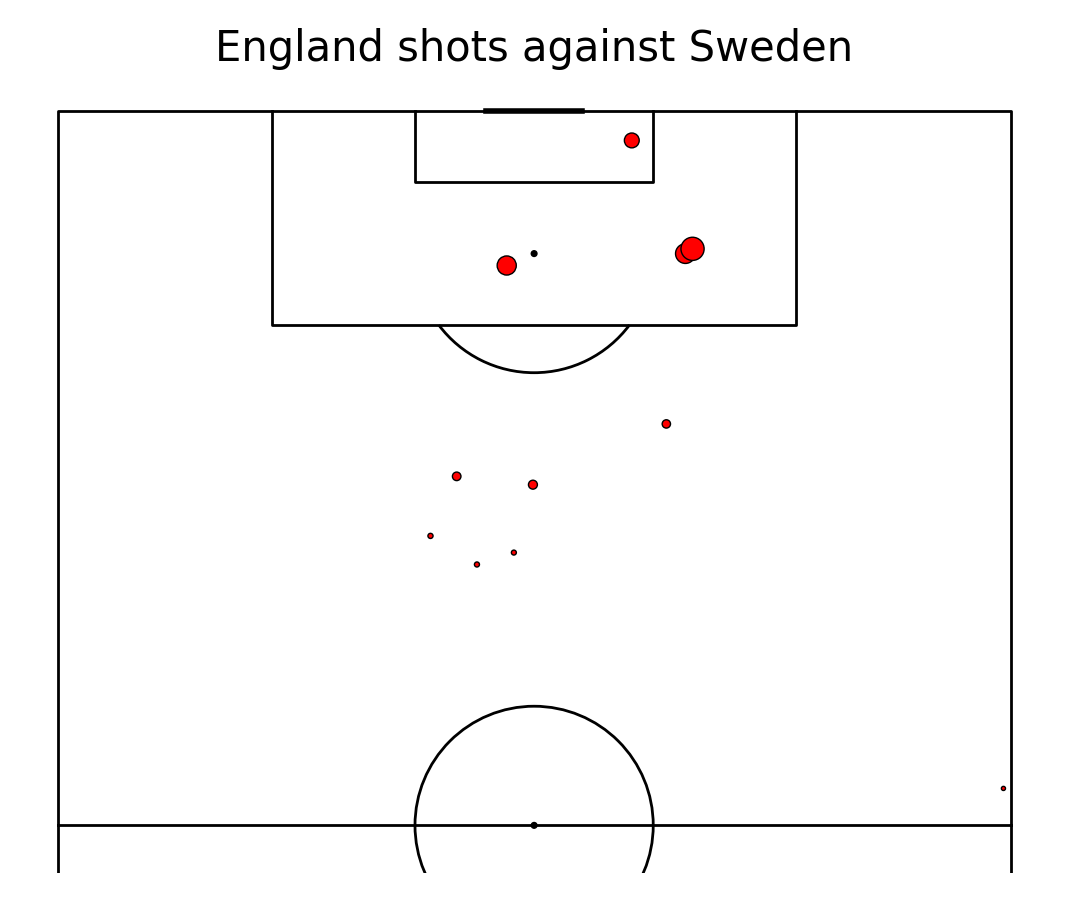

In [12]:
mask_england=(df_events.type_name=='Shot')&(df_events.team_name==team1)
df_england=df_events.loc[mask_england,['x','y','outcome_name','player_name','shot_statsbomb_xg']]
pitch=VerticalPitch(line_color='black',half=True)
fig,ax=pitch.grid(grid_height=0.9,title_height=0.06,axis=False,endnote_height=0.04,title_space=0,endnote_space=0)
pitch.scatter(df_england.x,df_england.y,alpha=1,s=df_england.shot_statsbomb_xg*2000,color='red',edgecolors='black',ax=ax['pitch'])
fig.suptitle("England shots against Sweden",fontsize=30)
plt.show()

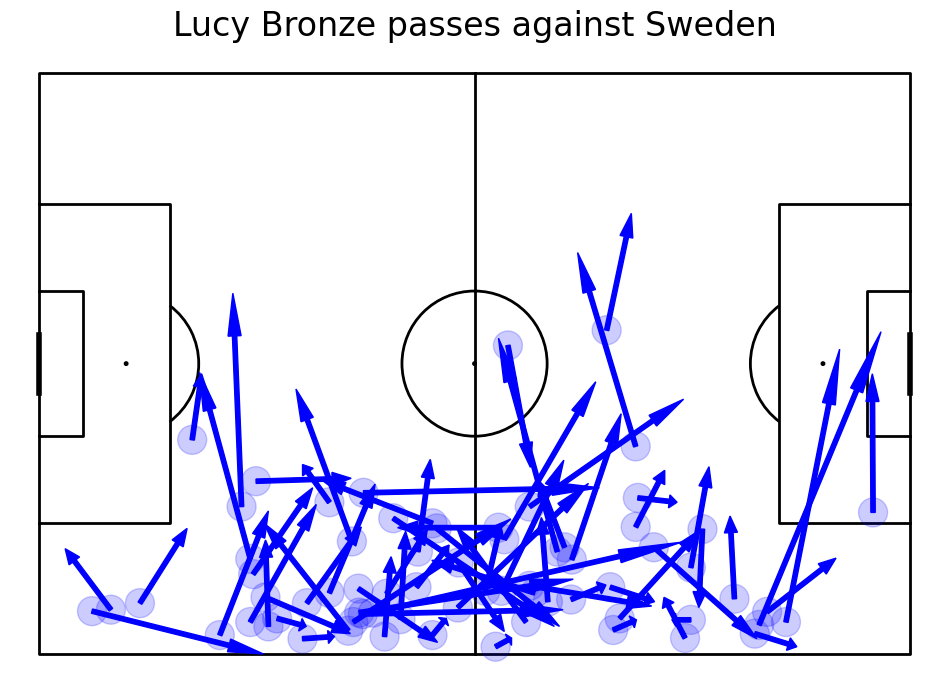

In [13]:
passes=df_events.loc[df_events['type_name']=='Pass'].loc[df_events["sub_type_name"]!="Throw-in"].set_index('id')
pitch=Pitch(line_color='black')
fig,ax=pitch.draw(figsize=(10,7))
for i,thepass in passes.iterrows():
    if thepass['player_name']=='Lucy Bronze':
        x=thepass['x']
        y=thepass['y']
        passCircle=plt.Circle((x,y),2,color="blue")
        passCircle.set_alpha(0.2)
        ax.add_patch(passCircle)
        dx=thepass['end_x']-x
        dy=thepass['end_y']-y
        passArrow=plt.Arrow(x,y,dx,dy,width=3,color="blue")
        ax.add_patch(passArrow)
ax.set_title("Lucy Bronze passes against Sweden",fontsize=24)
fig.set_size_inches(10,7)
plt.show()

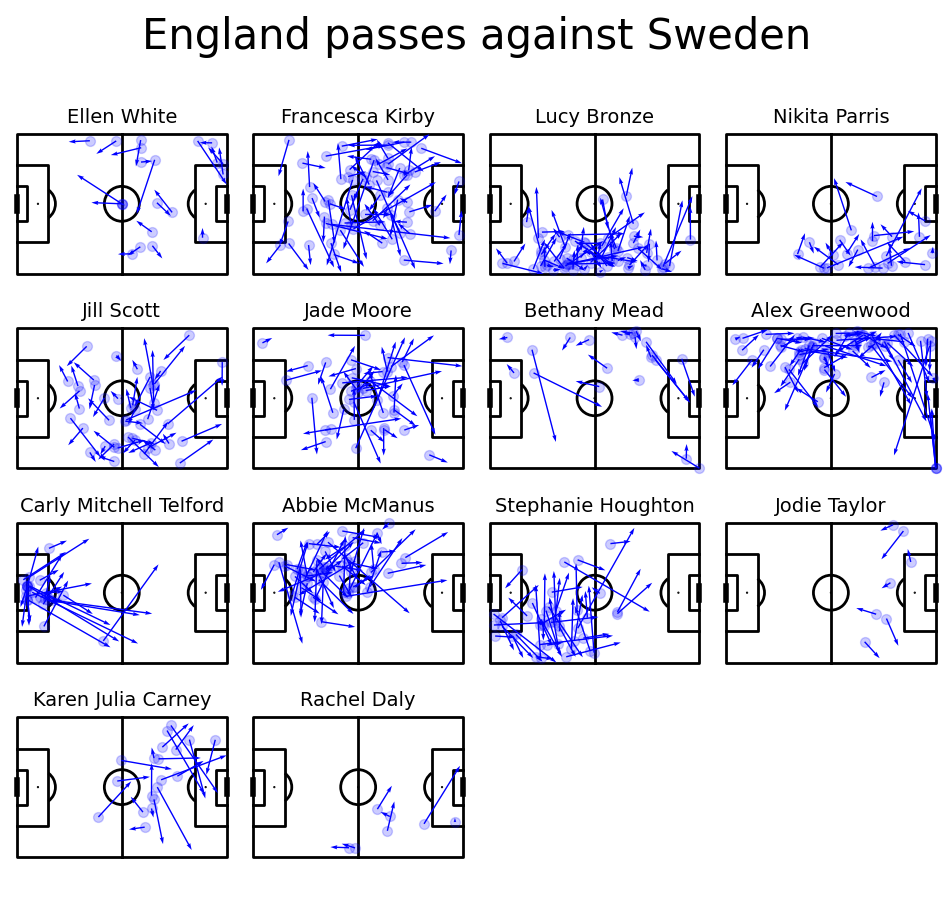

In [14]:
mask_england=(df_events.type_name=='Pass')&(df_events.team_name==team1) & (df_events.sub_type_name!="Throw-in")
df_passes=df_events.loc[mask_england,['x','y','end_x','end_y','player_name']]
names=df_passes.player_name.unique()
pitch=Pitch(line_color='black',pad_top=20)
fig,axs=pitch.grid(nrows=4,ncols=4,grid_height=0.85,title_height=0.06,axis=False,endnote_height=0.04,title_space=0.04,endnote_space=0.01)
for name,ax in zip(names,axs['pitch'].flat[:len(names)]):
    ax.text(60,-10,name,ha='center',va='center', fontsize=14)
    player_df=df_passes.loc[df_passes["player_name"]==name]
    pitch.scatter(player_df.x,player_df.y,alpha=0.2,s=50,color='blue',ax=ax)
    pitch.arrows(player_df.x,player_df.y,player_df.end_x,player_df.end_y,color="blue",ax=ax,width=1)
for ax in axs['pitch'][-1,16-len(names):]:
    ax.remove()
axs['title'].text(0.5,0.5,"England passes against Sweden",ha='center',va='center',fontsize=30)
plt.show()

In [15]:
sub = df_events.loc[df_events["type_name"] == "Substitution"].loc[df_events["team_name"] == "England Women's"].iloc[0]["index"]
#make df with successfull passes by England until the first substitution
mask_england = (df_events.type_name == 'Pass') & (df_events.team_name == "England Women's") & (df_events.index < sub) & (df_events.outcome_name.isnull()) & (df_events.sub_type_name != "Throw-in")
#taking necessary columns
df_pass = df_events.loc[mask_england, ['x', 'y', 'end_x', 'end_y', "player_name", "pass_recipient_name"]]
#adjusting that only the surname of a player is presented.
df_pass["player_name"] = df_pass["player_name"].apply(lambda x: str(x).split()[-1])
df_pass["pass_recipient_name"] = df_pass["pass_recipient_name"].apply(lambda x: str(x).split()[-1])

In [16]:
scatter_df = pd.DataFrame()
for i, name in enumerate(df_pass["player_name"].unique()):
    passx = df_pass.loc[df_pass["player_name"] == name]["x"].to_numpy()
    recx = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_pass.loc[df_pass["player_name"] == name]["y"].to_numpy()
    recy = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name
    #make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    #calculate number of passes
    scatter_df.at[i, "no"] = df_pass.loc[df_pass["player_name"] == name].count().iloc[0]

#adjust the size of a circle so that the player who made more passes 
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

In [17]:
df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
#setting a treshold. You can try to investigate how it changes when you change it.
lines_df = lines_df[lines_df['pass_count']>2]

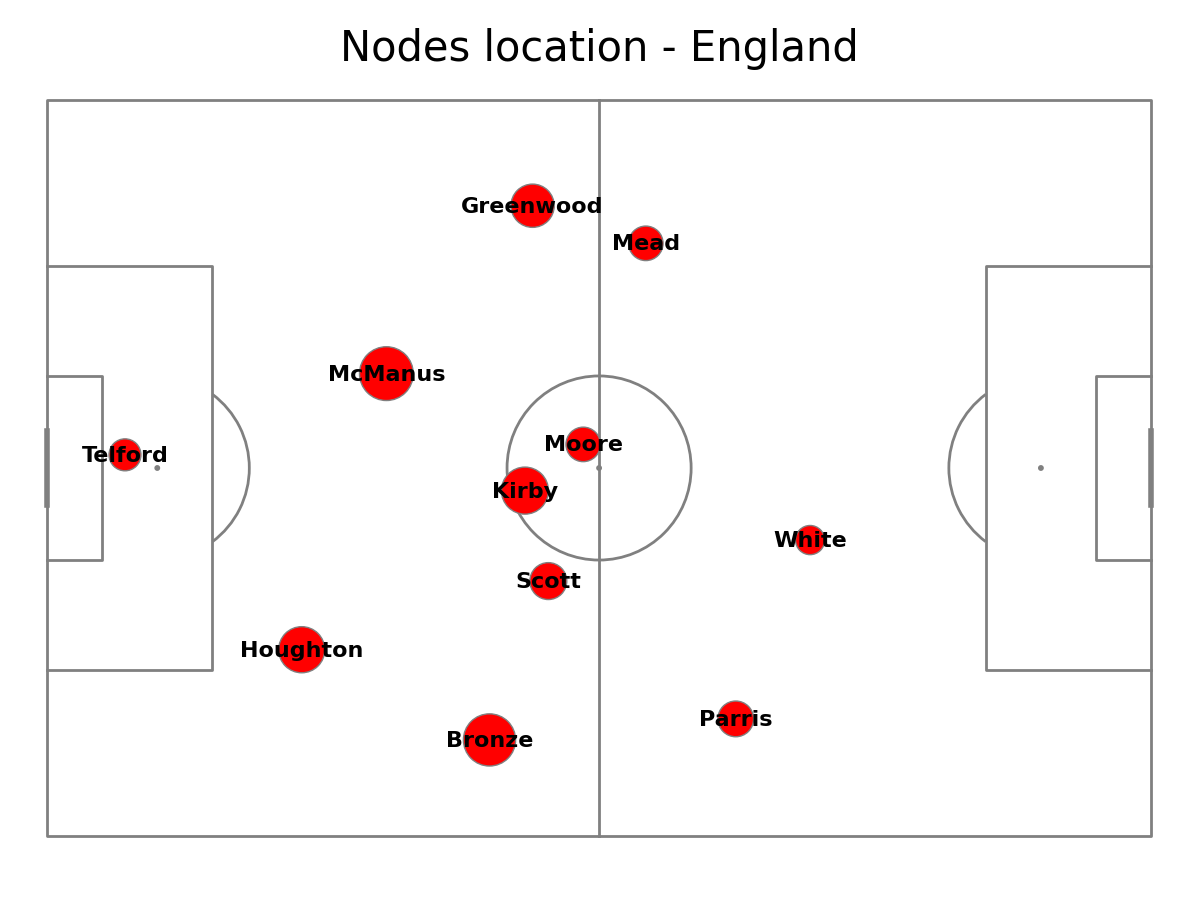

In [18]:
#Drawing pitch
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#Scatter the location on the pitch
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
#annotating player name
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

fig.suptitle("Nodes location - England", fontsize = 30)
plt.show()

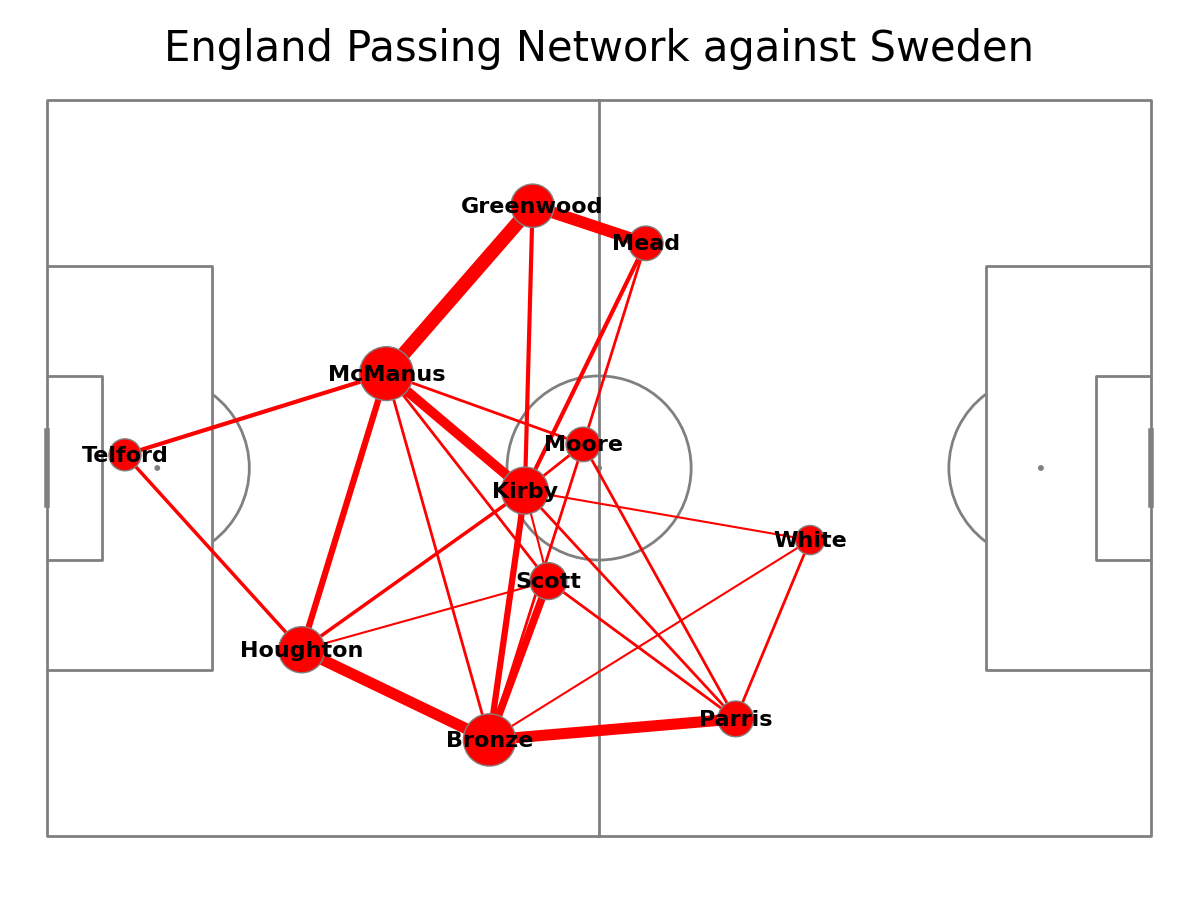

In [19]:
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)
    
for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #take the average location of players to plot a line between them 
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df['pass_count'].max() * 10)
        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=1, lw=line_width, zorder=2, color="red", ax = ax["pitch"])

fig.suptitle("England Passing Network against Sweden", fontsize = 30)
plt.show()

In [21]:
#calculate number of successful passes by player
no_passes = df_pass.groupby(['player_name']).x.count().reset_index()
no_passes.rename({'x':'pass_count'}, axis='columns', inplace=True)
#find one who made most passes
max_no = no_passes["pass_count"].max() 
#calculate the denominator - 10*the total sum of passes
denominator = 10*no_passes["pass_count"].sum() 
#calculate the nominator
nominator = (max_no - no_passes["pass_count"]).sum()
#calculate the centralisation index
centralisation_index = nominator/denominator
print("Centralisation index is ", centralisation_index)

Centralisation index is  0.07
